# Decision Trees and Random Forests

---
<b>Lab 4: Decision Tree and Random Forests</b>
- Principles of a supervised learning process
- Decision Trees
- Random Forests
---

- Romain Billot            
- Yannis Haralambous        
- Philippe Lenca         
- Sorin Moga    

## Data presentation (as from Kaggle.com)

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912,
during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224
passengers and crew. This sensational tragedy shocked the international community and led to better
safety regulations for ships.<br/>
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for
the passengers and crew. Although there was some element of luck involved in surviving the sinking, some
groups of people were more likely to survive than others, such as women, children, and the upper-class.
In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive.
In particular, we ask you to apply the tools of machine learning to predict which passengers survived the
tragedy.

<em>–The Titanic dataset–<br/></em>
<b>SPECIAL NOTES:</b>

\begin{array}{rr} \hline
Slot (not\ variable) & Meaning \\ \hline
transactionInfo &Data\ frame\ with\ vectors\ of\ the\ same\ length\ as\ the\ number\ of\ transactions  \\ \hline
Survival&   Survival(0=No;1=Yes) \\ \hline
pclass&   Passenger\ class( 1=1st,2=2nd,3=3rd)    \\ \hline
name&Name       \\  \hline
sex& Sex \\  \hline
age&         Age\\  \hline
sipsp&          Number\ of\ Sibling\ / Spouses\ Aboard              \\  \hline
parch&     Number\ of\ Parents\  /children\ Aboard                   \\  \hline
ticket&     Ticket\ Number                    \\  \hline
fare&        Ticket\ Fare\\  \hline
cabin&                  Cabin      \\  \hline
embarked&                    Port\ of\ Embarkation\ (C=Cherbourg\;Q= Queenstow\; S=Southampton)    \\  \hline
data&      Binary\ incidence\ matrix\ that\ indicates\ which\ item\ labels\ appear\ in\ every\ transaction\                   \\  \hline
\ \ \ \ \ \ \ Table 1\ : Structure\ of\ the\ titanic\ dataset\
\end{array}

<i>
- Pclass is a proxy for socio-economic status (SES): 1st Upper; 2nd Middle; 3rd Lower;
- Age is in Years; Fractional if Age less than One (1). If the Age is Estimated, it is in the form xx.5 <br/>
<mark>With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored. The
following are the definitions used for sibsp and parch.</mark>
- Sibling: Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic,
- Spouse: Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored),
- Parent: Mother or Father of Passenger Aboard Titanic,
- Child: Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic.
</i>


<mark>Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and inlaws.
Some children travelled only with a nanny, therefore parch=0 for them. As well, some travelled
with very close friends or neighbors in a village, however, the definitions do not support such relations.</mark>

In [1]:
#import needed libraries:
import pandas as pd
from sklearn import tree
import numpy as np
import re
#import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

### Question 1

Load, understand and describe carefully the train.csv and test.csv files. Look at the number of
people who survived. Create a new column in the test set that will contain your prediction that
everyone dies

In [2]:
# load your datasets here: train and test dataset
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']

In [3]:
# this function should print: shape of both dataset and the proportion of died passengers 
def answer_1():
    
    train_shape=train.shape
    test_shape=test.shape
    rate_died=1-train.Survived.describe()[1]

    
    print('==================Answer_1===========================\n')
    print('the shape of train dataset is:', train_shape,'\n')
    print('the shape of test dataset is:', test_shape,'\n')
    print('the proportion of died passengers is :',rate_died*100,'%')

    

answer_1()
    
    

==================Answer_1===========================

the shape of train dataset is: (891, 12) 

the shape of test dataset is: (418, 11) 

the proportion of died passengers is : 61.6161616162 %


<mark>The train set contains 891 observations (passengers) with 12 variables while the test set is small
with 418 passengers. The principle of a machine learning process is to learn a model on the train
set and then to test on the test set, hence testing with a dataset which has not been used in the
learning process. With respect to the proportions of survival, we see that 61% of the passengers
died.</mark>

### Question 2

Then we can analyze gender pattern. The disaster was famous for saving "women and children
first", so let’s take a look at the Sex and Age variables to see if any patterns are evident. We’ll
start with the gender of the passengers.Take a look at the summary
of this variable. Build a cross table that shows the proportions of males and females crossed
with the survival variable.(help: use the crosstab function)

In [4]:
# this function should print a summary about the 'Sex' variable then a cross table showing the proportions of males and females
# crossed with the survival variable
def answer_2():
    gender_summary=train.Sex.describe()
    cross_table=pd.crosstab(train.Sex, train.Survived).apply(lambda r: r/r.sum(), axis=1)
    cross_table2=train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean'])

    
    print('==================Answer_2===========================\n')
    print(' The summary of gender is :\n', gender_summary,'\n')
    print('The needed crossed table is:\n', cross_table )
    print('alternative for cross tab is :\n',cross_table2)
    
answer_2()


==================Answer_2===========================

 The summary of gender is :
 count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object 

The needed crossed table is:
 Survived         0         1
Sex                         
female    0.257962  0.742038
male      0.811092  0.188908
alternative for cross tab is :
         Survived
            mean
Sex             
female  0.742038
male    0.188908


<mark> We can see that the majority of females aboard survived, and a very low percentage of males did
survive</mark>

### Question 3

Now we are going to work on the age. Look at the age distribution with descriptive statistics.
Then create a new variable <b>Child</b> which takes one if the passenger is below 18 years old, 0 otherwise.
Add this variable to the train dataset. Then create a table with both gender and age to see
the survival proportions for different subsets.

In [8]:
def answer_3():
    
    age_descriptive=train.Age.describe()
    train['Child']=0
    train.Child[train.Age<18]=1
    
    '''
    # you can use a loop also but it is quit slow if you have a big datset, the above solution is more fast
    for i in range (train.shape[0]):
        if(train['Age'][i]<18):
            train['Child'][i]=1
    '''
    cross_table2=train[['Sex','Child', 'Survived']].groupby(['Sex','Child'], as_index=False).agg(['mean'])
    cross_table3=train[['Child', 'Survived']].groupby(['Child'], as_index=False).agg(['mean'])


    print('===================Answer_3==============================\n')
    print('The age descriptive is:\n',age_descriptive,'\n')
    print('The needed crossed table is:\n', cross_table2,'\n')
    print('Optional:\n', cross_table3)



answer_3()

===================Answer_3==============================

The age descriptive is:
 count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64 

The needed crossed table is:
               Survived
                  mean
Sex    Child          
female 0      0.752896
       1      0.690909
male   0      0.165703
       1      0.396552 

Optional:
        Survived
           mean
Child          
0      0.361183
1      0.539823


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Question 4

Next we focus on the fare which is a continuous variable that needs to be reduced to something
that can be easily tabulated. Let’s bin the fares into less than 10 dollars, between 10 and 20, 20 to
30 and more than 30 and store it to a new variable. Use the aggregate function again in order to
highlight some relevant crossed proportions.

In [9]:
def  answer_4():
    
    Fare_descriptive=train.Fare.describe()
    train['Fare2']='+30'
    train.Fare2[((train.Fare<30) & (train.Fare>=20))]='20-30'
    train.Fare2[(train.Fare<20)&(train.Fare>=10)]='10-20'
    train.Fare2[train.Fare<10]='<10'
    
    cross_table2=train[['Sex','Fare2','Pclass' ,'Survived']].groupby(['Sex','Fare2','Pclass'], as_index=False).agg(['mean'])

    print('===================Answer_4==============================\n')
    print('The fare descriptive is:\n',Fare_descriptive,'\n')
    print('The needed crossed table is:\n', cross_table2)
    
answer_4()

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


===================Answer_4==============================

The fare descriptive is:
 count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64 

The needed crossed table is:
                      Survived
                         mean
Sex    Fare2 Pclass          
female +30   1       0.977273
             2       1.000000
             3       0.125000
       10-20 2       0.914286
             3       0.581395
       20-30 1       0.833333
             2       0.900000
             3       0.333333
       <10   3       0.593750
male   +30   1       0.383721
             2       0.214286
             3       0.240000
       10-20 2       0.158730
             3       0.236842
       20-30 1       0.400000
             2       0.160000
             3       0.125000
       <10   1       0.000000
             2       0.000000
             3       0.111538


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<mark>While the majority of males, regardless of class or fare still don’t do so well, we notice that most
of the class 3 women who paid more than 20 dollars for their ticket actually also miss out on a
lifeboat.
It’s a little hard to imagine why someone in third class with an expensive ticket would be worse off
in the accident, but perhaps those more expensive cabins were located close to the iceberg impact
site, or further from exit stairs?</mark>

- <b>The code below is inspired from Kaggle</b> with little changes: https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset

## Decision Trees

In the first part of the lab, we have tried to find subsets of the passengers that were more, or less, likely
to survive the disaster. To find more fine-grained subsets with predictive ability would require a lot of
time to adjust our bin sizes and look at the interaction of many different variables. In this section, we
are going to illustrate, step by step, the implementation of a decision tree algorithm. Decision trees have
a number of advantages. They are what’s known as a glass-box model, after the model has found the
patterns in the data you can see exactly what decisions will be made for unseen data that you want to
predict. They are also intuitive and can be read by people with little experience in machine learning
after a brief explanation. Finally, they are the basis for some of the most powerful and popular machine
learning algorithms. Conceptually, the algorithm starts with all of the data at the root node (drawn at
the top) and scans all of the variables for the best one to split on. The way it measures this is to make
the split on the variable that results in the most pure nodes below it, i.e with either the most 1’s or the
most 0’9s in the resulting buckets.

In [7]:
# Before going deeper and apply decision tree or Random Forest, we prefer begin with some feature engineering


### Question  5

Execute and understand the following code that makes some variable engineering in order to improve data quality and sense and improve the results. Execute BLOCK by BLOCK and spend some time to understand each BLOCK.

#### Block 1

In [10]:
# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


In [11]:
print('============== Block 1 =======================')
print('the first element in Cabin is:',train['Cabin'][0],' and its type is',type(train['Cabin'][0]))
print(train['Cabin'][0:4],'\n',train["Has_Cabin"][0:4])
# we observe that all Nan values are mapped to be 0s, others to 1s

# the Cabin features contains either str  or nan elements. 


============== Block 1 =======================
the first element in Cabin is: nan  and its type is <class 'float'>
0     NaN
1     C85
2     NaN
3    C123
Name: Cabin, dtype: object 
 0    0
1    1
2    0
3    1
Name: Has_Cabin, dtype: int64


#### Block 2

In [13]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1  # 1 is for the current passenger

#### Block 3

In [14]:
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

#### Block 4

In [15]:
train['Embarked'].isnull().sum()
# you can see that we have 'nan' in Embarked

2

In [16]:
# we have one nan value on test dataset
test['Fare'].isnull().sum()

1

In [14]:
# for Fare we do not have any nan value
train['Fare'].isnull().sum()

0

In [17]:
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

##### Block 5

In [18]:
print(test.Age.isnull().sum(),train.Age.isnull().sum())
print(np.random.randint(0,5,20))  # gives 20 random numbers between 0 ( inclusive ) and 5 ( exclusive)


86 177
[1 2 4 0 1 1 3 3 4 0 1 3 3 1 1 3 1 0 1 1]


In [19]:
# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

#### Block 6

In [21]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)  #" do not hesitate to tap shift+tab(just at the right of the name function
    #) to see the function documentation "
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

#### Block 7

In [22]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

#### Block 8

In [23]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

#### Block 9

In [24]:
# Feature selection: remove variables no longer containing relevant information
drop_elements_train = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Fare2','Child']
drop_elements_test = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']


train = train.drop(drop_elements_train, axis = 1)
test  = test.drop(drop_elements_test, axis = 1)

#### Block 10

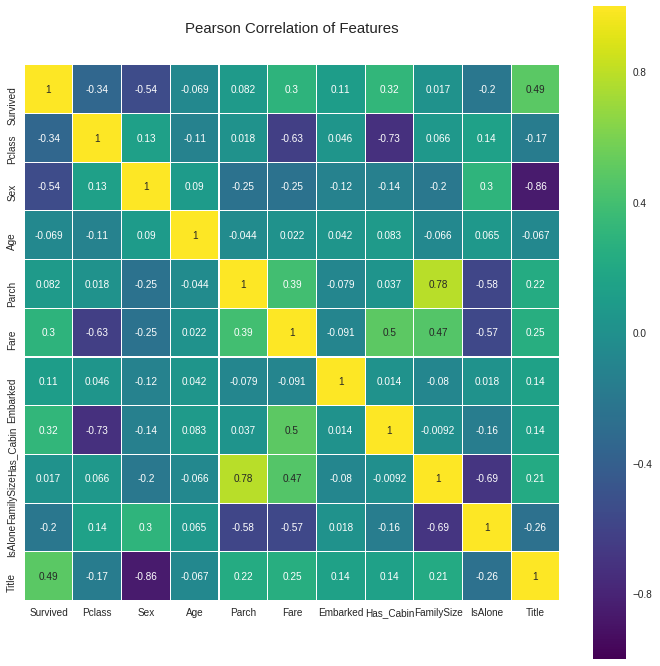

In [25]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

<mark> The figure above shows clearly that the target variable 'Survived' correlates strongly with 'Title' and 'Sex'</mark>

### Question 6:


Draw a first decision tree
for only the gender variable Sex by using the <b>tree</b> package. 

In [26]:

# This function should return a tree fitted using the libraries provided
def answer_5():
    # choose the needed features and the dependent variable
    features=['Sex','Survived']
    new_train=train[features]
    # the target function
    y_train = new_train['Survived']
    #  training data as an array
    x_train = new_train.drop(['Survived'], axis=1).values
    
    
    # Create Decision Tree 
    clf = tree.DecisionTreeClassifier()
    clf=clf.fit(x_train, y_train)
    return clf



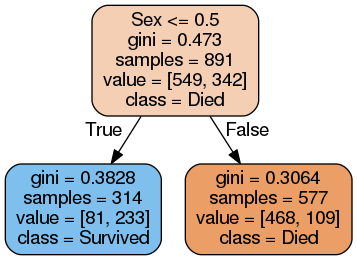

In [27]:

# run the code below to see your tree
# Export our trained model as a .dot file
features=['Sex','Survived']
new_train=train[features]
with open("tree1.dot", 'w') as f:
    f = tree.export_graphviz(answer_5(),
                            out_file=f,
                            impurity = True,
                            feature_names = list(new_train.drop(['Survived'], axis=1)),
                            class_names = ['Died', 'Survived'],
                            rounded = True,
                            filled= True )

    #Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

    # Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
img.save('sample-out.png')
PImage("sample-out.png")
    

# note: Sex<=0.5: for female. As a recall we have mapped female to 0.

<mark>The root node, at the top, shows first insights, 62%(549/891) of passengers died, while 38% survived. The
class below these values indicates the way that the node is voting (recall we decided at
this top level that everyone would die, and the samples indicates the
proportion of the population that resides in this node, or bucket (here at the top level it is everyone,
100%).
So far, so good. Now let’s travel down the tree branches to the next nodes down the tree. If the
passenger was a male, indicated by the boolean choice below the node, you move right, and if female,
left. The survival proportions exactly match those we found with the proportion tables.
If the passenger was male, only 19% survive, so the bucket votes that everyone here (65% of passengers)
perish, while the female bucket votes in the opposite manner, most of them survive as we
saw before. In fact, the above decision tree is an exact representation of the gender model. The
final nodes at the bottom of the decision tree are known as terminal nodes, or sometimes as leaf
nodes. After all the boolean choices have been made for a given passenger, they will end up in
one of the leaf nodes, and the majority vote of all passengers in that bucket determine how we will
predict for new passengers with unknown fates. </mark>

### Question 7



Build a more complex tree with a refined model composed of all possible variables. For that purpose,
just change the question 5.

In [28]:
def answer_6():
    y_train = train['Survived']
    x_train = train.drop(['Survived'], axis=1).values 
    x_test = test.values
    
    
    # Create Decision Tree 
    clf = tree.DecisionTreeClassifier(max_depth=3)
    clf=clf.fit(x_train, y_train)
    return clf


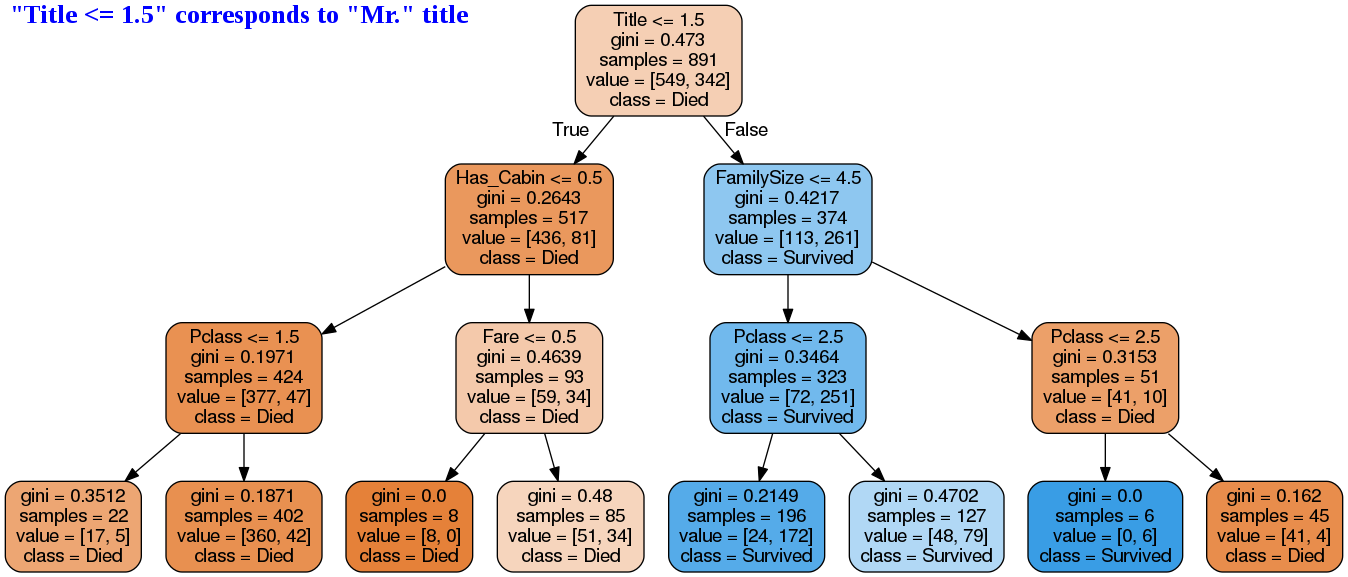

In [29]:

# run the code below to see your tree
# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
    f = tree.export_graphviz(answer_6(),
                            out_file=f,
                            max_depth=3,
                            impurity = True,
                            feature_names = list(train.drop(['Survived'], axis=1)),
                            class_names = ['Died', 'Survived'],
                            rounded = True,
                            filled= True )

    #Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

    # Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255), # RGB desired color
          font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")


<mark>The decisions that have been found
go a lot deeper than what we saw last time when we looked for them manually. Decisions have
been found for the SipSp variable. And on the male side, the kids younger than 6 years old have a better chance of survival.</mark>

### Question 8

From the tree previously built, make a prediction for the survival status of each passenger in the
test dataset. Put the results into a dataframe and write it into a csv file as if you were preparing a
submission to a machine learning contest.

In [30]:
x_test = test.values
# Predicting results for test dataset
y_pred = answer_6().predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

## Random Forests

Decision trees are faced with overfitting issues. To overcome these limitation, an ensemble method known
as random forest is very popular in the machine learning community. The principe is to build a lot of
different models, named weak classifiers, i.e an ensemble of simple decision trees, and let their outcomes
be averaged or voted across the group. 

### Question 9

Build your first Random Forest model using all features

In [31]:
def answer_9():
    y_train = train['Survived']
    x_train = train.drop(['Survived'], axis=1).values 
    x_test = test.values

    
    
    
    # Create Decision Tree 
    clf = RandomForestClassifier(n_jobs=2)
    clf=clf.fit(x_train, y_train)
    
    return clf
answer_9()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Question 10

print the features importance

In [32]:
def answer_10():
    # View a list of the features and their importance scores
    feature_importance=list(zip(train[train.columns[1:]], answer_9().feature_importances_))
    return feature_importance
answer_10()

[('Pclass', 0.098926133347242179),
 ('Sex', 0.1810949061308316),
 ('Age', 0.094612059019695494),
 ('Parch', 0.040367619512234491),
 ('Fare', 0.099584566467863428),
 ('Embarked', 0.057537003390426986),
 ('Has_Cabin', 0.05516831073370547),
 ('FamilySize', 0.1086459497972158),
 ('IsAlone', 0.02238678175823915),
 ('Title', 0.24167666984254538)]

<mark>As confirmation, we notice the higher importance of gender and Title</mark>